In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
from datetime import datetime, timedelta
print(os.getcwd())
sys.path.append('../')
from cognite.correlation.correlation import columns_by_max_cross_correlation
from cognite.client import CogniteClient
import pandas as pd
import numpy as np
import json

client = CogniteClient(client_name='test-corr')
location = 'hydrocyclones_tags.json'
tags_json = json.load(open(location, 'r'))


/Users/marcel/Documents/github/correlation/notebooks


/Users/marcel/.conda/envs/correlation-ranking/lib/python3.7/site-packages/cognite/client/_cognite_client.py:57: UserWarning: You are using version 1.0.0a33 of the SDK, however version 1.0.0a35 is available. Upgrade or set the environment variable 'COGNITE_DISABLE_PYPI_VERSION_CHECK' to suppress this warning.
  debug=debug,
/Users/marcel/.conda/envs/correlation-ranking/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Authenticated towards inferred project 'akerbp'. Pass project to the CogniteClient constructor or set the environment variable 'COGNITE_PROJECT' to suppress this warning.
  if sys.path[0] == '':


In [32]:
def read_dict_tree(tree):
    out = []
    for key, subtree in tree.items():
        if type(subtree) == dict:
            out += map(lambda x: key + '/' + x, read_dict_tree(subtree))
        else:
            out.append(key + '~' + subtree)
    return out
tag_list = read_dict_tree(tags_json)
tag_list = sorted(list(set(tag_list)))
tags = pd.DataFrame({'description': list(map(lambda x: x.split('~')[0], tag_list)),
                     'CDF_TAG':     list(map(lambda x: x.split('~')[1], tag_list))})
tags.drop_duplicates(subset='CDF_TAG', inplace=True)
print(tags.shape, '\n', tags.head())
description_map = {key: val for val, key in (x.split('~') for x in tag_list)}


(53, 2) 
                                         description  \
0                          TURRET_CHOKE/Vilje/TM DS   
1                            TURRET_CHOKE/BOA/TM US   
2                         TURRET_CHOKE/Kneler B/PCV   
3    SEPARATORS/Alvheim Separator/Oil Level (Choke)   
4  SEPARATORS/Alvheim Separator/Water Level (choke)   

                        CDF_TAG  
0              16TT0514/Y/1mMID  
1              16TT0102/Y/1mMID  
2  16HCV0304/OutPosition/1mSAMP  
3    20LV0120A/OutPosition/PRIM  
4    20LV0220B/OutControl/1mMID  


In [37]:
# Retrieve data from CDF using ids
df = client.datapoints.retrieve_dataframe(
    # id=tags['id'].to_list(),
    external_id=tags['CDF_TAG'].to_list(),
    start=datetime(2019, 6, 30, 0, 0),
    end=datetime(2019, 7, 4, 0, 0),
    granularity='1s',
    aggregates=['interpolation']
)

print(df.head())

                     16TT0514/Y/1mMID|interpolation  \
2019-06-30 00:00:00                             NaN   
2019-06-30 00:00:01                             NaN   
2019-06-30 00:00:02                             NaN   
2019-06-30 00:00:03                             NaN   
2019-06-30 00:00:04                             NaN   

                     16TT0102/Y/1mMID|interpolation  \
2019-06-30 00:00:00                       57.129597   
2019-06-30 00:00:01                             NaN   
2019-06-30 00:00:02                             NaN   
2019-06-30 00:00:03                             NaN   
2019-06-30 00:00:04                             NaN   

                     16HCV0304/OutPosition/1mSAMP|interpolation  \
2019-06-30 00:00:00                                         NaN   
2019-06-30 00:00:01                                         NaN   
2019-06-30 00:00:02                                         NaN   
2019-06-30 00:00:03                                         NaN   
201

In [38]:
# Rename columns
import re
df.columns = list(map(lambda x: re.sub('\|interpolation', '', x), df.columns))
df.columns = list(map(lambda x: description_map[x], df.columns))


In [39]:
# Interpolate data
df.interpolate(inplace=True)
df.fillna(method='bfill', inplace=True)
df.dropna(how='all', axis=1, inplace=True)


In [68]:
# Info about the dataframe
print(np.min(df.index.to_series().diff()))
print('Shape of df:', df.shape)
print('NaN count:', df.isna().sum().sum())
print('\n'.join(map(str, enumerate(df.columns))))


0 days 00:00:01
Shape of df: (345600, 51)
NaN count: 0
(0, 'TURRET_CHOKE/Vilje/TM DS')
(1, 'TURRET_CHOKE/BOA/TM US')
(2, 'TURRET_CHOKE/Kneler B/PCV')
(3, 'SEPARATORS/Alvheim Separator/Oil Level (Choke)')
(4, 'HYDROCYCLONES/HP Hydrocyclones B/Calculated outlet flow (water)')
(5, 'TURRET_CHOKE/BOA/PT DS')
(6, 'TURRET_CHOKE/East Kameleon/PT US')
(7, 'TURRET_CHOKE/Vilje/PCV')
(8, 'SEPARATORS/Alvheim Separator/PT')
(9, 'TURRET_CHOKE/Vilje/PT DS')
(10, 'TURRET_CHOKE/East Kameleon/TM US')
(11, 'HYDROCYCLONES/LP Hydrocyclones/dP water')
(12, 'HYDROCYCLONES/HP Hydrocyclones A/Reject dP control')
(13, 'CHEMICALS/Scale inhibitor/Level')
(14, 'HYDROCYCLONES/HP Hydrocyclones A/Inlet flow Alvheim')
(15, 'SEPARATORS/3rd Party Separator/TM')
(16, 'SEPARATORS/3rd Party Separator/Oil Level')
(17, 'SEPARATORS/3rd Party Separator/Water Level (choke)')
(18, 'SEPARATORS/Alvheim Separator/WiO')
(19, 'TURRET_CHOKE/Volund/TM US')
(20, 'TURRET_CHOKE/Kneler B/TM US')
(21, 'SEPARATORS/Alvheim Separator/TM')
(22, 

In [67]:
import cognite.correlation
# Find correlation with optimal lag
lags = pd.timedelta_range(start=timedelta(minutes=-60), end=timedelta(), periods=5*60)
# print(lags)
correlate_to = df.columns[47]
correlations, cross = cognite.correlation.columns_by_max_cross_correlation(df, correlate_to, lags, return_cross_correlation_df=True)
print(correlations)


                                                  col      corr      lag
0            WATER_QUALITY/Dump / Injection water/OiW  1.000000 00:00:00
1                  SEPARATORS/3rd Party Separator/WiO  0.154826 00:30:31
2                         CHEMICALS/Demulsifier/Level  0.113226 00:29:54
3                     SEPARATORS/Alvheim Separator/PT  0.102315 00:22:53
4                   SEPARATORS/3rd Party Separator/PT  0.090219 00:41:45
5                      TURRET_CHOKE/East Kameleon/PCV  0.057581 00:00:00
6                              TURRET_CHOKE/Vilje/PCV  0.056298 00:00:00
7   HYDROCYCLONES/LP Hydrocyclones/Inlet Flow 2nd ...  0.039661 00:02:25
8                    TURRET_CHOKE/East Kameleon/TM US  0.023942 00:00:00
9                 TURRET_CHOKE/Kneler A + Bøyla/TM DS  0.018952 00:20:41
10                           TURRET_CHOKE/Vilje/TM US -0.022427 01:00:00
11                           TURRET_CHOKE/Vilje/TM DS -0.029187 00:48:58
12                   TURRET_CHOKE/East Kameleon/PT 

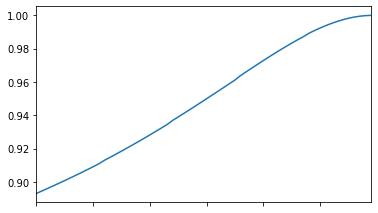

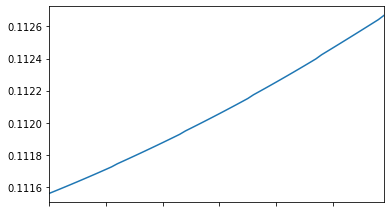

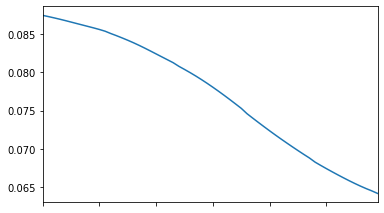

In [64]:
# Plot cross correlation over time
import matplotlib.pyplot as plt
for colname in correlations['col'][:3]:
    cross[colname].plot()
    plt.gcf().set_facecolor('white')
    plt.show()


